## Fama French 3 Factor Model

Yan Wu<br/>
yanwu26@gmail.com <br/>
October 2016

#### Description:

When pricing stocks, Fama–French three-factor model, designed by Eugene Fama and Kenneth French, describes stock returns through statistical means. The three factors are 1. company Size, 2. company Price-to-Book Ratio, and 3. Market Risk. The traditional asset pricing model, known formally as the capital asset pricing model (CAPM) uses only one variable to describe the returns of a portfolio or stock with the returns of the market as a whole. Fama–French model adds two more variables. 

Fama and French started with the observation that two classes of stocks have tended to do better than the market as a whole: (i) small caps and (ii) stocks with a low Price-to-Book ratio (P/B, customarily called value stocks, contrasted with growth stocks). They then added two factors to CAPM to reflect a portfolio's exposure to these two classes.

For this scenario, we've chosen the FMI International Fund (FMIJX) as the fund and MSCI ACWI ex US as the benchmark (ACWX)

All data, tools, and code are publicly available. No guarantee of data accuracy.


In [4]:
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from pandas_datareader import data as wb
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
params = {'legend.fontsize': 'x-large','figure.figsize': (15, 10),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}#,'axes.facecolor': 'white'}
pylab.rcParams.update(params)

#### Get Fama French Data from Dartmouth's Tuck school website

These date are publicly available. More sophistocated factors are available, such as Barra, Axioma, Bloomberg, Quantal

In [124]:
url = urlopen("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip")
#Download Zipfile and create pandas DataFrame
zipfile = ZipFile(BytesIO(url.read()))
df_ff = pd.read_csv(zipfile.open('F-F_Research_Data_Factors_daily.CSV'), header = 0, names = ['Date','MKT-RF','SMB','HML','RF'], skiprows=3).dropna()
df_ff['Date'] = pd.to_datetime(df_ff['Date'], format = "%Y%m%d")
df_ff=df_ff.set_index('Date', drop=True)
#df_ff=df_ff/100 #convert to percentage
df_ff.tail(5)

,MKT-RF,SMB,HML,RF
Date,,,,
2016-10-25,-0.46,-0.58,0.22,0.001
2016-10-26,-0.23,-0.83,0.76,0.001
2016-10-27,-0.33,-0.98,0.58,0.001
2016-10-28,-0.29,-0.10,0.09,0.001
2016-10-31,0.02,0.04,0.15,0.001


### Get Vanguard Wellington Fund Data

Mutual Fund data are publically available from online sources. 

We need to:<br/>
1) Calculate the return daily<br/>
2) Convert to percentage so that the units line up with the Fama French Data<br/>
3) Remove NA's or other unecessary information and prepare for running the regression

In [122]:
#Get Data from Yahoo
start = '2004-12-31'
end = '2016-06-01'

df_px = wb.get_data_yahoo('VWELX', start, end)
df_px['ret']=df_px['Adj Close'].pct_change().dropna()
df_px=df_px.dropna()
#df_px['LnReturn'] = np.log(df_px['Adj Close']) - np.log(df_px['Adj Close'].shift(1))

#Combine Datasets, and calculate excess return

df_tot=pd.concat([df_ff,df_px['ret']], axis=1).dropna()
df_tot['ret_excess']=100*df_tot['ret'] - df_tot['RF']
#data2['XRtrn'] = (data2['LnReturn']*100 - data2['RF'])

df_tot.head(3)

,MKT-RF,SMB,HML,RF,ret,ret_excess
Date,,,,,,
2005-01-03,-0.97,-0.62,-0.04,0.008,-0.006956,-0.703596
2005-01-04,-1.30,-0.59,0.42,0.008,-0.009006,-0.908603
2005-01-05,-0.51,-1.11,0.01,0.008,-0.003366,-0.344583


### Run Regression

We set the independent variables as the X matrix, and then regress the dependent y. In our case, the Fama French factors are the independent variables and the Fund returns are the dependent variable

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 2.121e+04
Date:                Tue, 29 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:44:46   Log-Likelihood:                 1211.9
No. Observations:                2873   AIC:                            -2416.
Df Residuals:                    2869   BIC:                            -2392.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0076      0.003      2.567      0.0

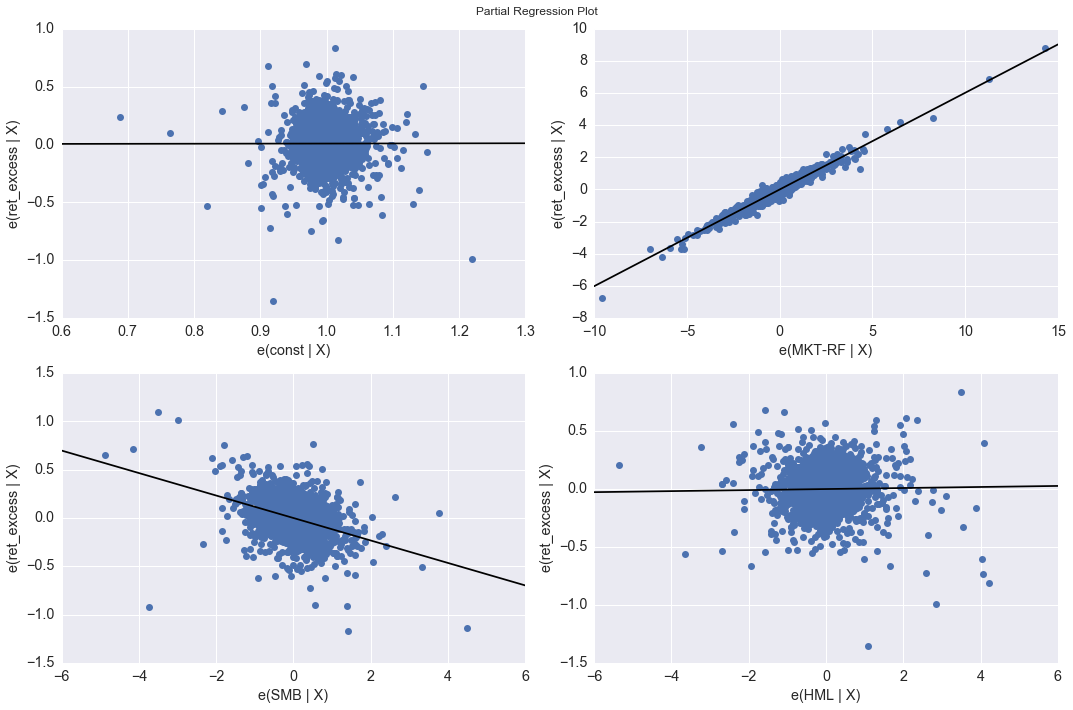

In [125]:
y = df_tot['ret_excess']
X = df_tot.ix[:,[0,1,2,]]
X = sm.add_constant(X) #add a constant for the regression model

model = sm.OLS(y, X)
results = model.fit()

#print model results and plot 
print(results.summary())
fig = plt.figure(figsize=(20,10))
#fig = sm.graphics.plot_partregress_grid(results, fig = fig)
fig = sm.graphics.plot_partregress_grid(results)


### Conclusions:

We see that the P-value of the F statistic is low, which means that the model is significant.

Within the model, we see that the Rsquared of the model is 95.7%, which means that the variance of the returns of the Fund is explained by 95.7% by the FF model.

Digging deep into the model, we see that the MKF and SMB have significant p-values. This suggests that the market is significant at explaining the returns and SMB is signficantly inverse at explaining the returns. The p-value for HML is insignificant, which means it does not have significant explanatory power. 

Finally, the coefficents for the MKT and SMB are 0.60 and -0.11. The Market coefficient, which commonly is referred to as beta, states that for each percent move of the market, the fund will move by 60%. This suggests that the fund is highly correlated with the market. The coefficient of SMB of -0.11 suggests that for every percentage move in SMB, the fund moves 11% in the opposite direction. This suggests that the fund is overweight in larger stocks and underweight in smaller stocks. You can see from the Morningstar Fund description that composition is nearly all in large/megacap stocks:

We ignore the coefficient of HML as it was not exaplantory. This suggests that the fund is evenly distributed amongst value and growth stocks. We can confirm this by looking on the morningstar style box.

http://portfolios.morningstar.com/fund/summary?t=VWELX&region=usa&culture=en-US



### Plotting Factors and Excess Returns

We plot the time series of all factors and the excess returns for illustrative purposes

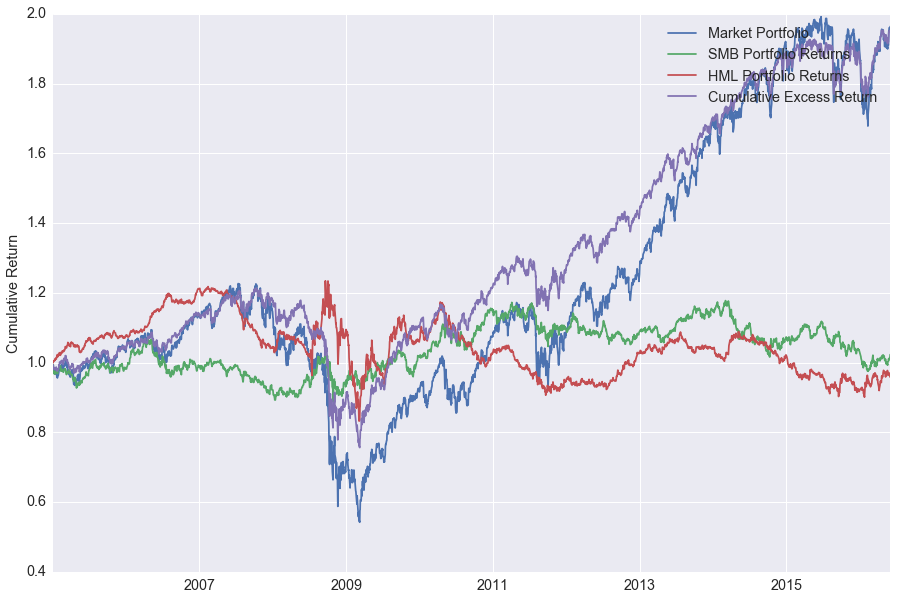

In [137]:
MKT_CUM = np.cumprod(df_tot['MKT-RF']/100+1)
SMB_CUM = np.cumprod(df_tot.SMB/100+1)
HML_CUM = np.cumprod(df_tot.HML/100+1)
FUND = np.cumprod(df_tot.ret_excess/100+1)
#FUND = np.cumprod(df_tot.ret+1)

plt.plot(MKT_CUM.index, MKT_CUM.values)
plt.plot(SMB_CUM.index, SMB_CUM.values)
plt.plot(HML_CUM.index, HML_CUM.values)
plt.plot(FUND.index, FUND.values)
plt.ylabel('Cumulative Return')
plt.legend(['Market Portfolio','SMB Portfolio Returns', 'HML Portfolio Returns','Cumulative Excess Return'])
#plt.legend(['SMB Portfolio Returns', 'HML Portfolio Returns']);